In [ ]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow_hub as hub

In [ ]:
wearing_masks = '//content//datas.zip'
local_zip = wearing_masks
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
img_shape = 224
train = ImageDataGenerator(rescale=1/255,
    rotation_range=5,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2,
	zoom_range=0.15,
	horizontal_flip=True
  )
validation = ImageDataGenerator(rescale=1/255,
    rotation_range=5,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2,
	zoom_range=0.15,
	horizontal_flip=True
  )


In [ ]:
train_path = '/tmp/datas/train'
validation_path = '/tmp/datas/test'
train_datagen = train.flow_from_directory(train_path,
                                          batch_size = 32,
                                          target_size = (img_shape,img_shape),
                                          class_mode = "binary")
validation_datagen = validation.flow_from_directory(validation_path,
                                          batch_size = 32,
                                          target_size = (img_shape,img_shape),
                                          class_mode = "binary")

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_datagen.class_indices

{'damage': 0, 'no_damage': 1}

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_acc')>=0.95):
            print("\nRequired accuracy is reached")
            self.model.stop_training= True
callbacks=myCallback()

#CNN DNN

In [ ]:
model = keras.Sequential([keras.layers.Conv2D(1028,(3,3),activation='relu',input_shape=(train_datagen[0][0].shape[1:])),
keras.layers.MaxPooling2D(2,2),
keras.layers.Dropout(0.2),
keras.layers.Conv2D(516,(3,3),activation='relu'),
keras.layers.MaxPooling2D(2,2),
keras.layers.Dropout(0.2),
keras.layers.Flatten(),
keras.layers.Dense(128,activation= 'relu'),
keras.layers.Dense(1,activation='sigmoid')
])

#RESNET50

In [ ]:
from tensorflow.keras.applications import ResNet50V2
from keras import layers
from tensorflow.keras.layers import Input

#Resnet50
feature_extractor_layer = ResNet50V2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_shape,img_shape,3)))

feature_extractor_layer.trainable = False

model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Flatten(name="flatten"),
    layers.Dense(1028, activation='relu', name='hidden_layer'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', name='output')
])

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer= Adam(lr=0.001),metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 hidden_layer (Dense)        (None, 1028)              103162884 
                                                                 
 dropout_2 (Dropout)         (None, 1028)              0         
                                                                 
 output (Dense)              (None, 1)                 1029      
                                                                 
Total params: 126,728,713
Trainable params: 103,163,913
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
history = model.fit(train_datagen,
                              validation_data = validation_datagen,
                              steps_per_epoch = 5,
                              epochs = 100,
                              callbacks=[callbacks],
                              verbose = 2)

Epoch 1/100
5/5 - 40s - loss: 14.7351 - acc: 0.5750 - val_loss: 8.6401 - val_acc: 0.7705 - 40s/epoch - 8s/step
Epoch 2/100
5/5 - 30s - loss: 9.4097 - acc: 0.7375 - val_loss: 6.4677 - val_acc: 0.7775 - 30s/epoch - 6s/step
Epoch 3/100
5/5 - 30s - loss: 8.8862 - acc: 0.7437 - val_loss: 4.4599 - val_acc: 0.8365 - 30s/epoch - 6s/step
Epoch 4/100
5/5 - 30s - loss: 2.6171 - acc: 0.8875 - val_loss: 7.4031 - val_acc: 0.7715 - 30s/epoch - 6s/step
Epoch 5/100
5/5 - 30s - loss: 4.0813 - acc: 0.8562 - val_loss: 3.0665 - val_acc: 0.8745 - 30s/epoch - 6s/step
Epoch 6/100
5/5 - 30s - loss: 2.4897 - acc: 0.8750 - val_loss: 3.4609 - val_acc: 0.8475 - 30s/epoch - 6s/step
Epoch 7/100
5/5 - 30s - loss: 2.2611 - acc: 0.8938 - val_loss: 2.2993 - val_acc: 0.8695 - 30s/epoch - 6s/step
Epoch 8/100
5/5 - 30s - loss: 1.2842 - acc: 0.8813 - val_loss: 2.2715 - val_acc: 0.8600 - 30s/epoch - 6s/step
Epoch 9/100
5/5 - 29s - loss: 1.2845 - acc: 0.9125 - val_loss: 1.8443 - val_acc: 0.8755 - 29s/epoch - 6s/step
Epoch 10/

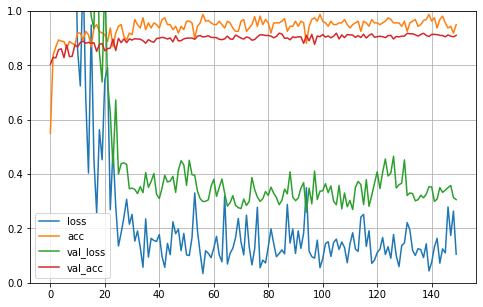

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()